In [1]:
experiment_name = "non_lin_data_ter"

In [2]:
import numpy as np
from scipy.spatial.distance import cosine
from scipy.linalg import svd, inv
import pandas as pd
import matplotlib.pyplot as plt
import dill as pickle
import os
import pdb
import torch
import ai.causalcell
from ai.causalcell.training import set_seed
from ai.causalcell.utils import configuration
os.chdir(os.path.join(os.path.dirname(ai.__file__), ".."))
print("Working in", os.getcwd())   

Working in /Users/paul/PycharmProjects/causal_cell_embedding


In [3]:
def load_all_losses(res, name='recon_loss'):
    all_train_loss = []
    for epoch in range(len(res['losses']['train'])):
        train_loss = np.mean([res['losses']['train'][epoch][i][name].detach().numpy() 
        for i in range(len(res['losses']['train'][epoch]))])
        all_train_loss.append(train_loss)
    all_valid_loss = []
    for epoch in range(len(res['losses']['valid'])):
        valid_loss = np.mean([res['losses']['valid'][epoch][i][name].numpy() 
        for i in range(len(res['losses']['valid'][epoch]))])
        all_valid_loss.append(valid_loss)
    return all_train_loss, all_valid_loss

In [4]:
def epoch_length(i):
    return results[i]['n_samples_in_split']['train']

In [5]:
def get_tube(x_coord, valid_loss1, valid_loss2, valid_loss3):
    min_length = min(len(valid_loss1), len(valid_loss2), len(valid_loss3))
    concat_lists = np.array([valid_loss1[:min_length], valid_loss2[:min_length], valid_loss3[:min_length]])
    st_dev_list = np.std(concat_lists, 0)
    mean_list = np.mean(concat_lists, 0)
#     pdb.set_trace()
    return x_coord[:min_length], mean_list, st_dev_list

In [6]:
result_dir = os.path.join(os.getcwd(), "results", experiment_name)

In [7]:
results = []
for exp_id in range(1, 37):
    with open(os.path.join(result_dir,'results_' 
              + str(exp_id) + '.pkl'), 'rb') as f:
        results.append(pickle.load(f))

In [8]:
all_exp_losses = []
for exp_id in range(36):
    all_exp_losses.append(load_all_losses(results[exp_id]))

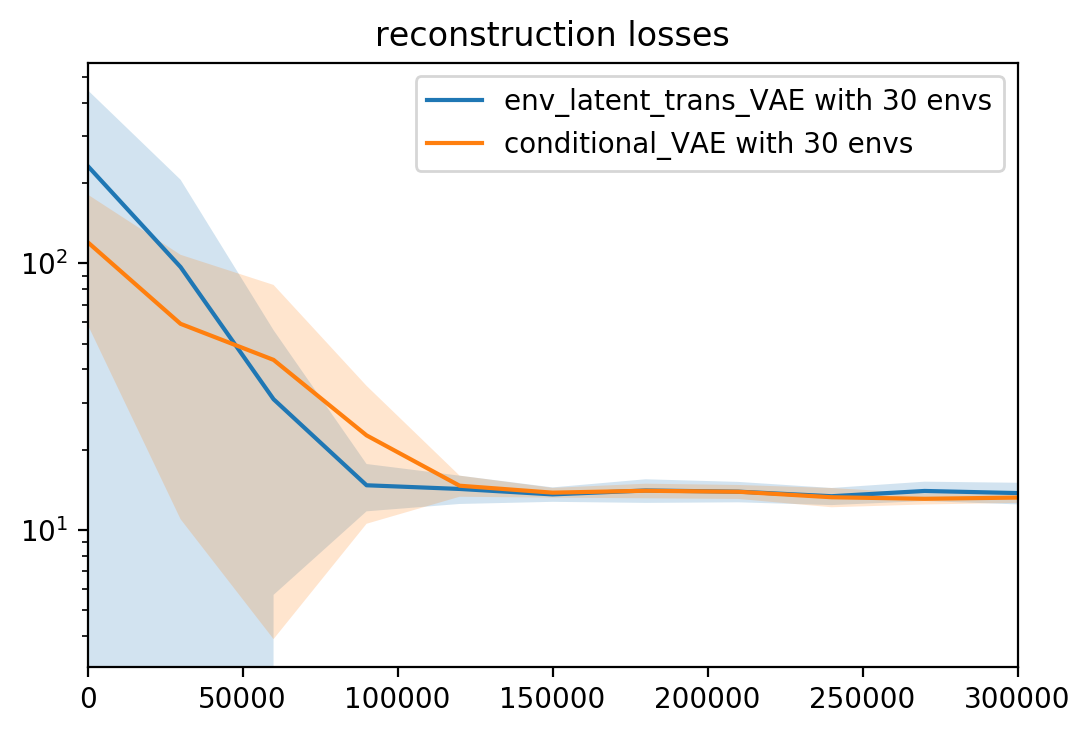

In [18]:
plt.figure(figsize=(6,4), dpi=200)
for i in [5]:
    for exp_id in [i, i+18]:
        valid_loss1 = all_exp_losses[exp_id][1]
        valid_loss2 = all_exp_losses[exp_id+6][1]
        valid_loss3 = all_exp_losses[exp_id+12][1]
        x_coord =  [epoch_length(exp_id)*i for i in range(len(valid_loss1))]
        x_coord_tube, mean_list, st_dev_list = get_tube(x_coord, valid_loss1, valid_loss2, valid_loss3)
        plt.fill_between(x_coord_tube, mean_list - st_dev_list, mean_list + st_dev_list, alpha=.2)
        label = list(results[exp_id]['config']['model'].keys())[0] \
        + " with " + str(list(results[exp_id]['config']['dataset']['train'].values())[0]['n_envs']) + " envs"
        plt.plot(x_coord_tube, mean_list, label=label)
    plt.title("reconstruction losses")
    plt.yscale("log")
    plt.xlim((0,300000))
    plt.legend()
plt.show()

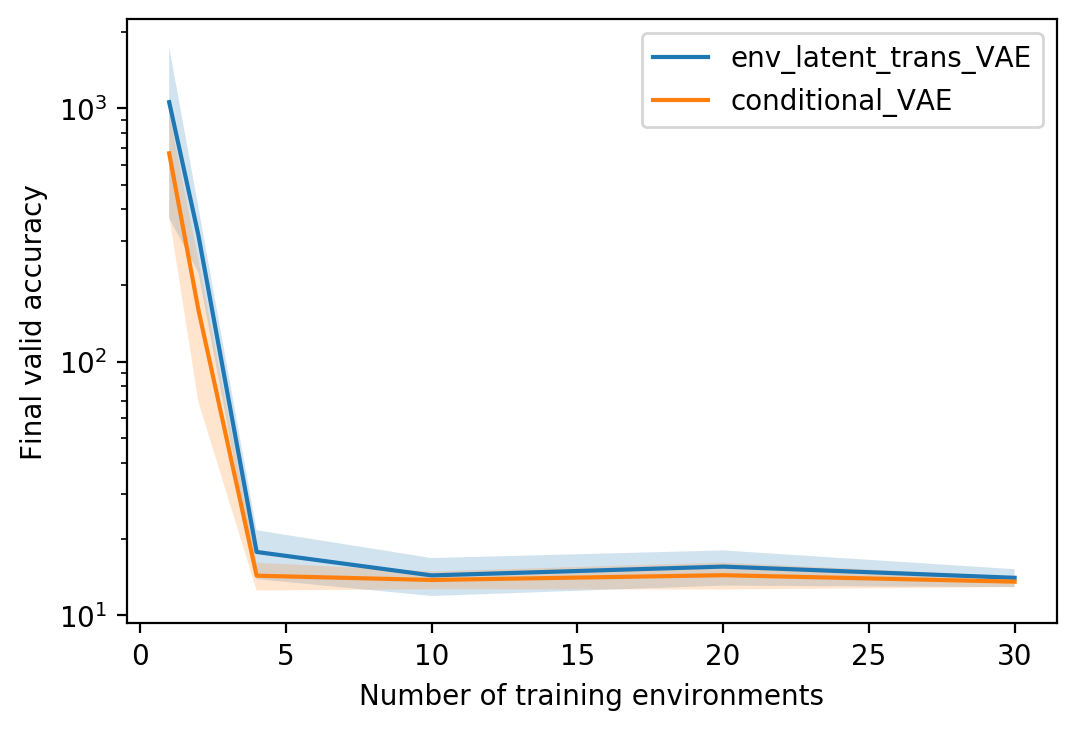

In [10]:
plt.figure(figsize=(6,4), dpi=200)
n_env_list = []
final_acc = []
final_acc_std = []
for exp_id in range(6):
    valid_loss1 = all_exp_losses[exp_id][1]
    valid_loss2 = all_exp_losses[exp_id+6][1]
    valid_loss3 = all_exp_losses[exp_id+12][1]
    x_coord =  [epoch_length(exp_id)*i for i in range(len(valid_loss1))]
    x_coord_tube, mean_list, st_dev_list = get_tube(x_coord, valid_loss1, valid_loss2, valid_loss3)
    
    n_env_list.append(list(results[exp_id]['config']['dataset']['train'].values())[0]['n_envs'])
    final_acc.append(mean_list[-1])
    final_acc_std.append(st_dev_list[-1])
    
final_acc = np.array(final_acc)
final_acc_std = np.array(final_acc_std)

plt.fill_between(n_env_list, final_acc - final_acc_std, final_acc + final_acc_std, alpha=.2)
plt.plot(n_env_list, final_acc, label="env_latent_trans_VAE")

n_env_list = []
final_acc = []
final_acc_std = []
for exp_id in range(18, 24):
    valid_loss1 = all_exp_losses[exp_id][1]
    valid_loss2 = all_exp_losses[exp_id+6][1]
    valid_loss3 = all_exp_losses[exp_id+12][1]
    x_coord =  [epoch_length(exp_id)*i for i in range(len(valid_loss1))]
    x_coord_tube, mean_list, st_dev_list = get_tube(x_coord, valid_loss1, valid_loss2, valid_loss3)
    
    n_env_list.append(list(results[exp_id]['config']['dataset']['train'].values())[0]['n_envs'])
    final_acc.append(mean_list[-1])
    final_acc_std.append(st_dev_list[-1])
    
final_acc = np.array(final_acc)
final_acc_std = np.array(final_acc_std)

plt.fill_between(n_env_list, final_acc - final_acc_std, final_acc + final_acc_std, alpha=.2)
plt.plot(n_env_list, final_acc, label="conditional_VAE")

plt.xlabel("Number of training environments")
plt.ylabel("Final valid accuracy")
plt.yscale("log")
plt.legend()
plt.show()